In [ ]:
!pip install deep_translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import regex as re
import string
from transformers import MarianMTModel, MarianTokenizer, BertModel, BertTokenizer, T5ForConditionalGeneration, T5Tokenizer,  BartForConditionalGeneration, BartTokenizer
import torch
from rouge_score import rouge_scorer
import os
#import evaluate
from unidecode import unidecode
# from spellchecker import SpellChecker
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from deep_translator import GoogleTranslator
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


## Step 1: Load and Inspect the Dataset

I load dataset and make a pandas data frame to represent it.

In [77]:
#df = pd.read_excel('./MeQSum.xlsx')
df = pd.read_excel('/content/drive/My Drive/Datasets/MeQSum.xlsx')

In [78]:
df.head()

,File,CHQ,Summary
0,1-131188152.xml.txt,SUBJECT: who and where to get cetirizine - D\n...,Who manufactures cetirizine?
1,14348.txt,who makes bromocriptine\ni am wondering what c...,Who manufactures bromocriptine?
2,1-131985747.xml.txt,SUBJECT: nulytely\nMESSAGE: Hello can you tell...,"Who makes nulytely, and where can I buy it?"
3,15410.txt,Williams' syndrome\nI would like to have my da...,Where can I get genetic testing for william's ...
4,35.txt,ClinicalTrials.gov - Question - general inform...,Where can I get genetic testing for multiple m...


As we can see, we have 3 columns , one of them is the file name that we export the text from it. the other column is the actual question text. and last column is summary of each question.

we have 1000 non null record.

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   File     1000 non-null   object
 1   CHQ      1000 non-null   object
 2   Summary  1000 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB


In [80]:
df.describe()

,File,CHQ,Summary
count,1000,1000,1000
unique,1000,1000,994
top,1-131188152.xml.txt,SUBJECT: who and where to get cetirizine - D\n...,What are the treatments for erectile dysfunction?
freq,1,1,4


## Step 2: Preprocessing

In this step I first define separate functions for each of the following strips.

first I lowercase all the text using text_lowercase() then by using remove_punctuation() i remove all punctuations then i define another function remove_symbols_and_alphanumeric() to remove any symbol except numbers and alphabetic characters. then in remove_link() i find the link patterns using regex and replace them with space.

in remove_html() i remove every pattern like HTML links.
unicode() is a function to remove all characters for example from another language keyboards.
and at the end i remove all extra white spaces with remove_whitespace().

In [81]:

def text_lowercase(text):
    return text.lower()

def remove_punctuation(text):
  return text.translate(str.maketrans('', '', string.punctuation))

def remove_symbols_and_non_alphanumeric(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

def remove_link(text):
  patterns = ['www.*\s+', 'https?.*\s+']
  for pattern in patterns:
    links = re.findall(pattern, text)
    for link in links:
      text = text.replace(link, ' ')
  return text

def remove_whitespace(text):
    return  " ".join(text.split())

def remove_html(text):
  return re.sub(r'<[^>]+>', '', text)

def remove_duplicates(text):
  words = text.split()
  return ' '.join(sorted(set(words), key=words.index))

# spell = SpellChecker()
# def check_spells(text):
#   corrected_words = [spell.correction(word) if spell.correction(word) is not None else word for word in text.split()]
#   return " ".join(corrected_words)

def remove_unnecessary_words(text):
  return re.sub(r'(SUBJECT:|MESSAGE:)', '', text)


ps = PorterStemmer()
def preprocess_data(text: str):

  text = remove_unnecessary_words(text)
  text = text_lowercase(text)
  text = remove_punctuation(text)
  text = unidecode(text)
  text = remove_symbols_and_non_alphanumeric(text)
  text = remove_link(text)
  text = remove_whitespace(text)
  text = remove_html(text)
  text = remove_duplicates(text)
  text = remove_whitespace(text)
  #text =  " ".join([ps.stem(word) for word in text.split()])

  return text


I apply the preprocess_data function on both questions and summaries.

In [82]:
df['CHQ'] = df['CHQ'].apply(preprocess_data)
df['Summary'] = df['Summary'].apply(preprocess_data)

In [83]:
df.head()

,File,CHQ,Summary
0,1-131188152.xml.txt,who and where to get cetirizine d i needwant k...,who manufactures cetirizine
1,14348.txt,who makes bromocriptine i am wondering what co...,who manufactures bromocriptine
2,1-131985747.xml.txt,nulytely hello can you tell me where do i orde...,who makes nulytely and where can i buy it
3,15410.txt,williams syndrome i would like to have my daug...,where can i get genetic testing for williams s...
4,35.txt,clinicaltrialsgov question general information...,where can i get genetic testing for multiple m...


## Step 3: Handling Missing or Irregular Data

it seems we don't have any null values. but we should check for cells with black or just spaces these are missing values too.

In [84]:
df.isnull().sum()

,0
File,0
CHQ,0
Summary,0


as we can see we don't have blanks either.

In [85]:
df[df['Summary'] == ""]

,File,CHQ,Summary


In [86]:
df.dropna(inplace=True)

I first calculate number of tokens for each question, then as we can see in the histogram we have the range 0 to 200, i remove the long questions those that have more than 120 tokens and also i remove questions with less than 5 tokens.
after that i keep just the first 120 tokens of each question in function pad_or_crop().

In [87]:
def get_words_count(text):
    return len(text.split())

In [88]:
df['len'] = df['CHQ'].apply(get_words_count)

In [89]:
df.describe()

,len
count,1000.000000
mean,42.840000
std,27.163804
min,2.000000
25%,23.000000
50%,36.000000
75%,55.000000
max,213.000000


<Axes: ylabel='Frequency'>

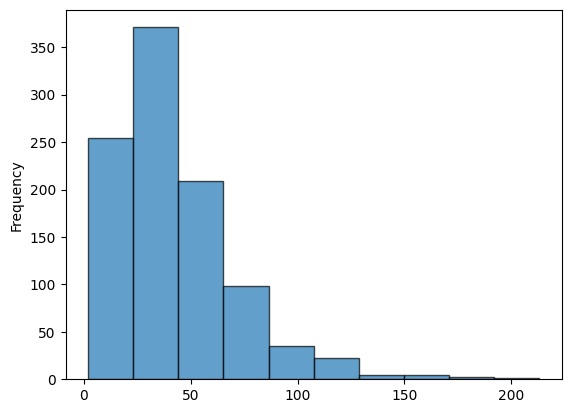

In [90]:
df['len'].plot(kind='hist', bins=10, edgecolor='black', alpha=0.7)


In [91]:
df = df[df['len'] > 5]
df = df[df['len'] < 150]

In [92]:
df

,File,CHQ,Summary,len
0,1-131188152.xml.txt,who and where to get cetirizine d i needwant k...,who manufactures cetirizine,24
1,14348.txt,who makes bromocriptine i am wondering what co...,who manufactures bromocriptine,65
2,1-131985747.xml.txt,nulytely hello can you tell me where do i orde...,who makes nulytely and where can i buy it,19
3,15410.txt,williams syndrome i would like to have my daug...,where can i get genetic testing for williams s...,25
4,35.txt,clinicaltrialsgov question general information...,where can i get genetic testing for multiple m...,52
...,...,...,...,...
995,1-136492342.xml.txt,after surgery of ear drum still same problem i...,what are the treatments for perforated eardrum,57
996,1-131298135.xml.txt,clinicaltrialsgov question specific study look...,what are the treatments for glycogen storage d...,42
997,NF_319.txt,i have numbnesstingling in my lower right arm ...,where can i find information and treatment for...,25
998,14372.txt,sleep apnea i was diagnosed with prolly had it...,how long does swelling from sleep apnea take t...,44


In [93]:
def pad_or_crop_text(text, length=120):
    if len(text.split()) > length:
        return " ".join(text.split()[:length])
    return text

In [94]:
df['CHQ'] = df['CHQ'].apply(pad_or_crop_text)

In [95]:
df

,File,CHQ,Summary,len
0,1-131188152.xml.txt,who and where to get cetirizine d i needwant k...,who manufactures cetirizine,24
1,14348.txt,who makes bromocriptine i am wondering what co...,who manufactures bromocriptine,65
2,1-131985747.xml.txt,nulytely hello can you tell me where do i orde...,who makes nulytely and where can i buy it,19
3,15410.txt,williams syndrome i would like to have my daug...,where can i get genetic testing for williams s...,25
4,35.txt,clinicaltrialsgov question general information...,where can i get genetic testing for multiple m...,52
...,...,...,...,...
995,1-136492342.xml.txt,after surgery of ear drum still same problem i...,what are the treatments for perforated eardrum,57
996,1-131298135.xml.txt,clinicaltrialsgov question specific study look...,what are the treatments for glycogen storage d...,42
997,NF_319.txt,i have numbnesstingling in my lower right arm ...,where can i find information and treatment for...,25
998,14372.txt,sleep apnea i was diagnosed with prolly had it...,how long does swelling from sleep apnea take t...,44


# Round-Trip Translation (RTT)

## Step 4 & 5: Translate Questions to a Pivot Language

### GoogleTranslate API

In this section i do the 2 side translation using google translate API, so for each pivot language we should call a function to first translate our question from english to the pivot language and then do the opposite means that do the translation from pivot language to english. we just pass the pivot language and english as source and target languages to the Google translate function.

here i just store the back-translated questions in the dataframe.

I do the same process for 5 given pivot languages and after this i merge all the translations questions from 5 languages..

In [ ]:
def RTT_api(text, target_lang="es"):
    try:
        translated = GoogleTranslator(source="en", target=target_lang).translate(text)
        back_translated = GoogleTranslator(source=target_lang, target="en").translate(translated)
        return back_translated
    except Exception as e:
        print(f"Error in translation: {e}")
        return text

def translate_api(df):

    es_df = df[['CHQ', 'Summary']]
    de_df = df[['CHQ', 'Summary']]
    it_df = df[['CHQ', 'Summary']]
    zh_df = df[['CHQ', 'Summary']]
    fr_df = df[['CHQ', 'Summary']]

    dataframes = {'es' : es_df, 'de': de_df, 'it': it_df, 'zh-CN': zh_df, 'fr': fr_df}

    for lang in ['es', 'de', 'it', 'zh-CN', 'fr']:
        dataframes[lang]["back-translated"] = df.apply(lambda x: RTT_api(x['CHQ'], target_lang=lang), axis=1)

    return pd.concat([es_df, de_df, it_df, zh_df, fr_df])


here i make a csv file and store the translated data and RTT results in that file to avoid doing the same process multiple times.
i also apply preprocessing function to the back-translated questions to be the same as the other questions.

In [ ]:
filename = "translated-data-api.csv"

for i in range(1):
    print(i)
    new_df  = translate_api(df.iloc[i*991:(i + 1)*991])

    new_df['back-translated'] = new_df['back-translated'].apply(preprocess_data)

    if os.path.exists(filename):
        existing_data = pd.concat([existing_data, new_df], ignore_index=True)
    else:
        pd.DataFrame(new_df).to_csv(filename, index=False, header=True)
        existing_data = pd.read_csv(filename)

    existing_data.to_csv(filename, index=False, header=True)

In [ ]:
existing_data.to_csv(filename, index=False, header=True)

In [ ]:
existing_data

In [76]:
api_df = pd.read_csv("/content/translated-data-api.csv")
api_df

,CHQ,Summary,back-translated
0,who and where to get cetirizin d i needwant kn...,who manufactur cetirizin,Who and where can I get cetirizine D? I need t...
1,who make bromocriptin i am wonder what compani...,who manufactur bromocriptin,Who makes bromocriptine? I'm wondering what co...
2,nulyt hello can you tell me where do i order t...,who make nulyt and where can i buy it,"Hello, can you tell me where I can order from ..."
3,william syndrom i would like to have my daught...,where can i get genet test for william syndrom,William Syndrome I would like my daughter to g...
4,clinicaltrialsgov question gener inform both m...,where can i get genet test for multipl myeloma...,Question from Clinicaltrialsgov: My parents di...
...,...,...,...
495,to anyon what can one do if they have no feel ...,what are the treatment for sensori loss in leg,to someone what can you do if you have no feel...
496,dailym feedback sir help me overcom incess fla...,what are the treatment for flatul,Daily Comments Sir please help me to overcome ...
497,fibrodysplasia ossifican progressiva i just re...,what are the treatment for fibrodysplasia ossi...,fibrodysplasia ossificans progressiva I just h...
498,eye i do see black thing what cous it or likd ...,what are the caus and treatment for eye floater,eyes i see something black what is it or like ...


#### MarianMTModel

In this step first we define the marian model. then we dp the translation for each text using batch translation to make the process more efficient.

in the perform_rtt function , first we define all translations models.
then we have a data frame for each language.
after that we do the translation from english to pivot language and store it in 'translated-CHQ' column.
after that we do the backward translation and translate from pivot language to english and store it in the 'back-translated' column.
after this i merge all the translations questions from 5 languages.

i do this process for each 100 records and then store the results in csv to avoid running the same process multiple times.

In Marian model translation we have several hyper parameters so we can set padding = True to model do the padding in the process and also we fix truncation = False to prevent losing information from texts. num_beams = 5 in the model.generate() means that the model will consider the top 5 possible sequences at each step of text generation, instead of just one and this increases the diversity of the generated text and improves the quality of the outputs.

In [ ]:
def batch_translate_texts(texts, model, tokenizer, batch_size=16):
    translated_texts = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=False)
        translated = model.generate(**inputs, num_beams = 5)
        translated_texts.extend([tokenizer.decode(t, skip_special_tokens=True) for t in translated])

    return translated_texts

def perform_rtt(df):

    lang_models = {
        'es': ('Helsinki-NLP/opus-mt-en-es', 'Helsinki-NLP/opus-mt-es-en'),
        'de': ('Helsinki-NLP/opus-mt-en-de', 'Helsinki-NLP/opus-mt-de-en'),
        'it': ('Helsinki-NLP/opus-mt-en-it', 'Helsinki-NLP/opus-mt-it-en'),
        'zh': ('Helsinki-NLP/opus-mt-en-zh', 'Helsinki-NLP/opus-mt-zh-en'),
        'fr': ('Helsinki-NLP/opus-mt-en-fr', 'Helsinki-NLP/opus-mt-fr-en')
    }

    models = {lang: (
        MarianMTModel.from_pretrained(src_model), MarianTokenizer.from_pretrained(src_model),
        MarianMTModel.from_pretrained(tgt_model), MarianTokenizer.from_pretrained(tgt_model)
    ) for lang, (src_model, tgt_model) in lang_models.items()}

    es_df = df[['CHQ', 'Summary']]
    de_df = df[['CHQ', 'Summary']]
    it_df = df[['CHQ', 'Summary']]
    zh_df = df[['CHQ', 'Summary']]
    fr_df = df[['CHQ', 'Summary']]

    dataframes = {'es' : es_df, 'de': de_df, 'it': it_df, 'zh': zh_df, 'fr': fr_df}

    batch_size = 16
    for lang, (model, tokenizer, model2, tokenizer2) in models.items():
        dataframes[lang][f'translated-CHQ'] = batch_translate_texts(dataframes[lang]['CHQ'].tolist(), model, tokenizer, batch_size)
        dataframes[lang][f'back-translated'] = batch_translate_texts(dataframes[lang][f'translated-CHQ'].tolist(), model2, tokenizer2, batch_size)

    return pd.concat([es_df, de_df, it_df, zh_df, fr_df])


In [ ]:
filename = "translated-data-marian.csv"
# it should be range(10) for all the records.
for i in range(9):
    print(i)
    new_df  = perform_rtt(df.iloc[i*100:(i + 1)*100])

    new_df['back-translated'] = new_df['back-translated'].apply(preprocess_data)

    if os.path.exists(filename):
        existing_data = pd.concat([existing_data, new_df], ignore_index=True)
    else:
        pd.DataFrame(new_df).to_csv(filename, index=False, header=True)
        existing_data = pd.read_csv(filename)

    existing_data.to_csv(filename, index=False, header=True)

0


/opt/anaconda3/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_955/1581696295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes[lang][f'translated-CHQ'] = batch_translate_texts(dataframes[lang]['CHQ'].tolist(), model, tokenizer, batch_size)
/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_955/1581696295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

1


/opt/anaconda3/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_955/1581696295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes[lang][f'translated-CHQ'] = batch_translate_texts(dataframes[lang]['CHQ'].tolist(), model, tokenizer, batch_size)
/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_955/1581696295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

2


/opt/anaconda3/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_955/1581696295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes[lang][f'translated-CHQ'] = batch_translate_texts(dataframes[lang]['CHQ'].tolist(), model, tokenizer, batch_size)
/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_955/1581696295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

3


/opt/anaconda3/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_955/1581696295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes[lang][f'translated-CHQ'] = batch_translate_texts(dataframes[lang]['CHQ'].tolist(), model, tokenizer, batch_size)
/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_955/1581696295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

4


/opt/anaconda3/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_955/1581696295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes[lang][f'translated-CHQ'] = batch_translate_texts(dataframes[lang]['CHQ'].tolist(), model, tokenizer, batch_size)
/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_955/1581696295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

5


/opt/anaconda3/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_955/1581696295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes[lang][f'translated-CHQ'] = batch_translate_texts(dataframes[lang]['CHQ'].tolist(), model, tokenizer, batch_size)
/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_955/1581696295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

6


/opt/anaconda3/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_955/1581696295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes[lang][f'translated-CHQ'] = batch_translate_texts(dataframes[lang]['CHQ'].tolist(), model, tokenizer, batch_size)
/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_955/1581696295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

7


/opt/anaconda3/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_955/1581696295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes[lang][f'translated-CHQ'] = batch_translate_texts(dataframes[lang]['CHQ'].tolist(), model, tokenizer, batch_size)
/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_955/1581696295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

8


/opt/anaconda3/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_955/1581696295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes[lang][f'translated-CHQ'] = batch_translate_texts(dataframes[lang]['CHQ'].tolist(), model, tokenizer, batch_size)
/var/folders/4q/400klzy115q8kws7mhtw544m0000gn/T/ipykernel_955/1581696295.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

KeyboardInterrupt: 

In [ ]:
filename = "translated-data-marian.csv"
# it should be range(10) for all the records.
for i in range(9):
    print(i)
    new_df  = perform_rtt(df.iloc[900:991])

    new_df['back-translated'] = new_df['back-translated'].apply(preprocess_data)

    if os.path.exists(filename):
        existing_data = pd.concat([existing_data, new_df], ignore_index=True)
    else:
        pd.DataFrame(new_df).to_csv(filename, index=False, header=True)
        existing_data = pd.read_csv(filename)

    existing_data.to_csv(filename, index=False, header=True)

In [ ]:
new_df

,CHQ,Summary,translated-CHQ,back-translated,len-back
0,who and where to get cetirizine d i needwant k...,who manufactures cetirizine,¿Quién y dónde conseguir cetirizina d i needwa...,who and where to get cetirizine d i needwant k...,24
1,who makes bromocriptine i am wondering what co...,who manufactures bromocriptine,¿Quién hace bromocriptina Me pregunto qué comp...,who makes bromocriptine i wonder what company ...,61
2,nulytely hello can you tell me where do i orde...,who makes nulytely and where can i buy it,Nulytely hola me puedes decir donde pedir el q...,nulytely hello you can tell me where to order ...,18
3,williams syndrome i would like to have my daug...,where can i get genetic testing for williams s...,síndrome de williams me gustaría que mi hija s...,williams syndrome i would like my daughter to ...,25
4,clinicaltrialsgov question general information...,where can i get genetic testing for multiple m...,clinicaltrialsgov pregunta información general...,clinicaltrialsgov asks general information bot...,53
...,...,...,...,...,...
3995,clinicaltrialsgov general complaint i am suffe...,what are the treatments for demyelinating sens...,clinicaltrialsgov plainte générale je souffre ...,clinicaltrialsgov general complaint i suffer f...,18
3996,kidney stone hello drin a case of patient with...,what are the treatments for kidney stones,pierre de rein bonjour drin un cas de patient ...,kidney stone hello drin a patient case with si...,20
3997,seeking help for a loved one hello i am my par...,where can i find information on and treatments...,chercher de l'aide pour un être cher bonjour j...,looking for help a loved one hello i am my par...,74
3998,hypothyroidism can you please send me as much ...,where can i find information on hypothyroidism...,hypothyroïdie pouvez-vous s'il vous plaît m'en...,hypothyroidismquot i has recently been diagnos...,30


In [ ]:
new_df = pd.read_csv("translated-data-marian.csv")

In [ ]:
new_df

,CHQ,Summary,translated-CHQ,back-translated
0,who and where to get cetirizine d i needwant k...,who manufactures cetirizine,¿Quién y dónde conseguir cetirizina d i needwa...,who and where to get cetirizine d i needwant k...
1,who makes bromocriptine i am wondering what co...,who manufactures bromocriptine,¿Quién hace bromocriptina Me pregunto qué comp...,who makes bromocriptine i wonder what company ...
2,nulytely hello can you tell me where do i orde...,who makes nulytely and where can i buy it,Nulytely hola me puedes decir donde pedir el q...,nulytely hello you can tell me where to order ...
3,williams syndrome i would like to have my daug...,where can i get genetic testing for williams s...,síndrome de williams me gustaría que mi hija s...,williams syndrome i would like my daughter to ...
4,clinicaltrialsgov question general information...,where can i get genetic testing for multiple m...,clinicaltrialsgov pregunta información general...,clinicaltrialsgov asks general information bot...
...,...,...,...,...
3995,clinicaltrialsgov general complaint i am suffe...,what are the treatments for demyelinating sens...,clinicaltrialsgov plainte générale je souffre ...,clinicaltrialsgov general complaint i suffer f...
3996,kidney stone hello drin a case of patient with...,what are the treatments for kidney stones,pierre de rein bonjour drin un cas de patient ...,kidney stone hello drin a patient case with si...
3997,seeking help for a loved one hello i am my par...,where can i find information on and treatments...,chercher de l'aide pour un être cher bonjour j...,looking for help a loved one hello i am my par...
3998,hypothyroidism can you please send me as much ...,where can i find information on hypothyroidism...,hypothyroïdie pouvez-vous s'il vous plaît m'en...,hypothyroidismquot i has recently been diagnos...


here we can see the number of tokens for back- translated questions. there are in the range of (0 - 100).

In [ ]:
new_df['len-back'] = new_df['back-translated'].apply(get_words_count)

<Axes: ylabel='Frequency'>

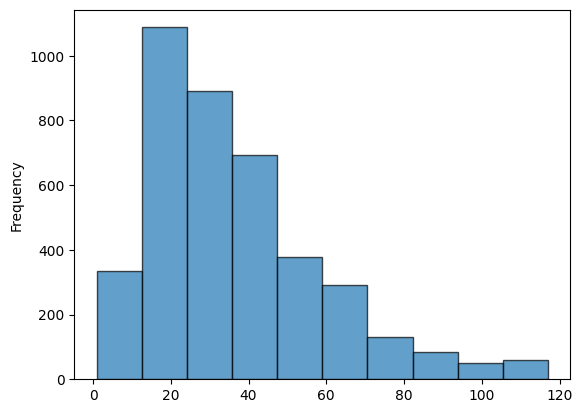

In [ ]:
new_df['len-back'].plot(kind='hist', bins=10, edgecolor='black', alpha=0.7)


## Step 6: Use FQD to select a subset of the new dataset

first we should embed each question to a vector, i do this using bert, and by .mean(dim = 1) i squeeze the embedded matrix to a one dimensional vector, because the default output of bert embedding is a matrix of shape (768 , len(text)) and what i do is that calculate the mean of all the vectors for each word to represent the text as a one dimensional vector.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

def bert_embedding(text, tokenizer, model):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=False)
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze(0).numpy()
    return embeddings


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

then after bert embedding we should calculate the FQD score that is same as cosine similarity using the given formula for each golden question and the generated ones.

In [ ]:
def compute_fqd(q1, q2):

    q1_embedding = bert_embedding(q1, tokenizer, model)
    q2_embedding = bert_embedding(q2, tokenizer, model)

    similarity = np.dot(q1_embedding, q2_embedding) / (np.linalg.norm(q1_embedding) * np.linalg.norm(q2_embedding))
    return 1 - similarity

then after calculating FQD scores for all records, we normalized them and pick those with scores between 0.2 and 0.8.
because the FQD scores more than this are those that are completely different from the golden question and less than 0.2 are those that are completely the same as the golden one.

In [ ]:
def select_questions_fqd(df):
    df['fqd'] = df.apply(lambda x: compute_fqd(x['CHQ'], x['back-translated']), axis=1)
    df['normalized-fqd'] = (df['fqd'] - df['fqd'].min()) /  (df['fqd'].max() - df['fqd'].min())
    return df[df['normalized-fqd'].between(0.2, 0.8)]

In [ ]:
selected_records_fqd = select_questions_fqd(new_df)

In [ ]:
selected_records_fqd

,CHQ,Summary,translated-CHQ,back-translated,len-back,fqd,normalized-fqd
328,normal physical traits but no period im a 40 y...,where can i find information on developmental ...,正常的生理特征 但是没有40岁的老妇人 患有幼年生殖器官 从未经历过绝经,normal physiological features but no 40yearold...,15,0.277154,0.302167
360,xlinked congenital stationary night blindness ...,what are the treatments for xlinked congenital...,{\fn黑体\fs22\bord1\shad0\3aHBE\4aH00\fscx67\fsc...,my brother has problems but its still not common,9,0.381418,0.415840
361,we appreciate your response my son is 24 years...,what are the treatments for wilsons disease an...,我们感谢你的回答 我儿子24岁 找不到任何药物治疗 以及医院 来防治维尔森病,we appreciate your response that my son is 24 ...,23,0.288438,0.314469
372,pulmonary tuberchlosis respected sirmadam i ta...,what are the treatments for lung fluid retenti...,肺肺管管肺病 受人尊重的热气母体 我接受过去两年的治疗 现在已经进入了第2阶段 我的X光报告...,ive been treated for the last two years and no...,18,0.312944,0.341186
380,male with breast i am a 51 year old and have e...,what are the treatments for gynecomastia,"我已经51岁了,而且我母亲已经长大了 说鸟胸的尺寸是36 b",im 51 years old and my mothers grown up,9,0.284806,0.310509
...,...,...,...,...,...,...,...
3815,hydrocortisone 1 cream i would like to know wh...,what are the ingredients of 1 hydrocortisone c...,一种甘油类或植物甘油类的甘油类 甘油类的甘油类的甘油类的甘油类的甘油类的 甘油类的甘油类的,the glycerine of a or plant,6,0.278869,0.304036
3827,heightened sense of smell is there any informa...,where can i find information about heighted or...,"有关于嗅觉敏感度的信息 我难以闻到香味和化学物的味道 特别是清洁,有时是扭曲的",i cant smell the scent and chemical especially...,11,0.286928,0.312822
3871,recovery after stroke what is the pattern of,what is the prognosis and course of recovery a...,中风后恢复恢复,recovered after stroke,3,0.387698,0.422687
3881,tracheomalacia my is so wide spread with 90 bl...,what is the prognosis for tracheomalacia,气管瘤拉西亚 我的血压分布如此广泛 90个封锁手术 没有一个选项 我戴O2247,i dont have an option to wear o2247,8,0.384723,0.419443


<Axes: ylabel='Frequency'>

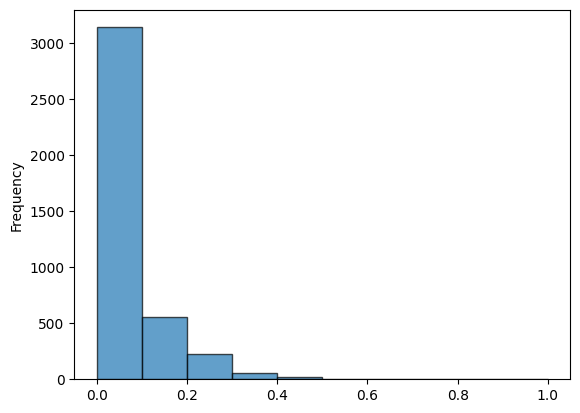

In [ ]:
new_df['normalized-fqd'].plot(kind='hist', bins=10, edgecolor='black', alpha=0.7)


In [ ]:
#selected_records_fqd = new_df[new_df['normalized-fqd'].between(0.5, 0.8)]

## Step 7: Use PRQD to select a subset of the new dataset

in this step after embedding like the previous step, we should calculate the PRQD score for each record.
and we do that with implementing the given formula.

and for choosing alpha i do the same process form a list of alphas and pick the one with maximum scores.

but we expect that f1 scores be between 0 and 1, but with these fromula they are negative and big numbers. so we define a softmax function and apply it to the column of PRQD scores to scale these numbers between 0 and 1.

and then we filter the generated questions and keep those with scores between 0.3 and 0.7. because the high score means that two questions are same questions.

In [ ]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))


In [ ]:
def compute_prqd(q1, q2):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    q1_embedding = bert_embedding(q1, tokenizer, model).reshape(-1, 1)
    q2_embedding = bert_embedding(q2, tokenizer, model).reshape(-1, 1)

    prqd_scores = []
    alphas = np.linspace(0.1, 1.0, 10)
    for alpha in alphas:
        precision = np.sum(np.minimum(q1_embedding, alpha * q2_embedding))
        recall = np.sum(np.minimum(q1_embedding / alpha, q2_embedding))

        prqd_score = (2 * precision * recall) / (precision + recall)
        prqd_scores.append(prqd_score)

    prqd_scores = softmax(np.array(prqd_scores))
    maximum = max(prqd_scores)

    return maximum


In [ ]:
def select_questions_prqd(df):
    df['prqd'] = df.apply(lambda x: compute_prqd(x['CHQ'], x['back-translated']), axis=1)
    return df[df['prqd'].between(0.3, 0.7)]

In [ ]:
selected_records_prqd = select_questions_prqd(new_df)

In [ ]:
new_df.to_csv("/content/new_df.csv", index=False, header=True)

<Axes: ylabel='Frequency'>

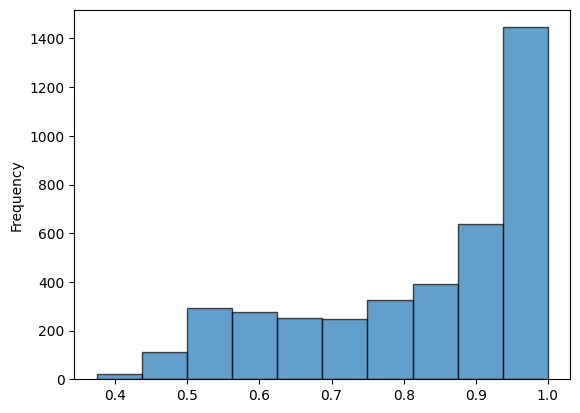

In [ ]:
new_df['prqd'].plot(kind='hist', bins=10, edgecolor='black', alpha=0.7)

In [ ]:
selected_records_prqd

,CHQ,Summary,translated-CHQ,back-translated,len-back,fqd,normalized-fqd,prqd
3,williams syndrome i would like to have my daug...,where can i get genetic testing for williams s...,síndrome de williams me gustaría que mi hija s...,williams syndrome i would like my daughter to ...,25,0.049174,0.053612,0.656693
4,clinicaltrialsgov question general information...,where can i get genetic testing for multiple m...,clinicaltrialsgov pregunta información general...,clinicaltrialsgov asks general information bot...,53,0.019926,0.021724,0.616347
12,pregnancy i just want to ask if have some ways...,where can i find information on tubal ligation...,embarazo sólo quiero preguntar si tener alguna...,i just want to ask if have any way or an opera...,24,0.066258,0.072238,0.605185
15,hello im sorry about my mom she has black her ...,what treatments are available for diabetic ski...,hola siento lo de mi mamá ella tiene negro su ...,hi sorry about my mom she has black her neck m...,33,0.041492,0.045236,0.654706
19,rectal prolapse my rectum is stretched out and...,where can i find information on rectal prolaps...,prolapso rectal mi recto está estirado y neces...,rectal prolapse my rectum is stretched and i n...,18,0.010000,0.010902,0.510575
...,...,...,...,...,...,...,...,...
3980,clinicaltrialsgov question general information...,what are the treatments for hereditary cerebel...,clinicaltrialsgov question informations généra...,clinicaltrialsgov question general information...,19,0.028656,0.031242,0.550088
3983,stem cell therapy for muccular dystrophy i hav...,how can i find physicians who specialize in li...,thérapie des cellules souches pour la dystroph...,stem cell therapy for muccular dystrophy i hav...,32,0.037448,0.040828,0.600751
3986,leg swelling my mother 57 age his from last 6 ...,where can i find information on leg swelling a...,Gonflement de la jambe ma mère 57 ans son des ...,swelling of the leg my mother 57 years sound l...,38,0.026141,0.028500,0.652111
3989,i would like to know what exactly causes the k...,what iare antikidd antibodies and how can they...,J'aimerais savoir quelles sont les causes exac...,i would like to know the exact causes of diagn...,44,0.043647,0.047586,0.636927


# Summarization

## Step 9: Use pre-trained models to summarize questions

In [ ]:
df

,File,CHQ,Summary,len
0,1-131188152.xml.txt,who and where to get cetirizine d i needwant k...,who manufactures cetirizine,24
1,14348.txt,who makes bromocriptine i am wondering what co...,who manufactures bromocriptine,65
2,1-131985747.xml.txt,nulytely hello can you tell me where do i orde...,who makes nulytely and where can i buy it,19
3,15410.txt,williams syndrome i would like to have my daug...,where can i get genetic testing for williams s...,25
4,35.txt,clinicaltrialsgov question general information...,where can i get genetic testing for multiple m...,52
...,...,...,...,...
995,1-136492342.xml.txt,after surgery of ear drum still same problem i...,what are the treatments for perforated eardrum,57
996,1-131298135.xml.txt,clinicaltrialsgov question specific study look...,what are the treatments for glycogen storage d...,42
997,NF_319.txt,i have numbnesstingling in my lower right arm ...,where can i find information and treatment for...,25
998,14372.txt,sleep apnea i was diagnosed with prolly had it...,how long does swelling from sleep apnea take t...,44


here we should first make the extended datasets . I mean merge the raw dataset with the new selected questions from the last step. so we make a new dataframe that contains both questions from FQD selection and the original questions. and the Summary column contains the given summary for each question.

we do the same thing fot the selected questions from PRQD distance measure.

In [ ]:
extended_df_fqd = pd.DataFrame()

extended_df_fqd['CHQ'] =  pd.concat([df['CHQ'], selected_records_fqd['back-translated']])
extended_df_fqd['Summary'] =  pd.concat([df['Summary'], selected_records_fqd['Summary']])

In [ ]:
extended_df_fqd

,CHQ,Summary
0,who and where to get cetirizine d i needwant k...,who manufactures cetirizine
1,who makes bromocriptine i am wondering what co...,who manufactures bromocriptine
2,nulytely hello can you tell me where do i orde...,who makes nulytely and where can i buy it
3,williams syndrome i would like to have my daug...,where can i get genetic testing for williams s...
4,clinicaltrialsgov question general information...,where can i get genetic testing for multiple m...
...,...,...
3815,the glycerine of a or plant,what are the ingredients of 1 hydrocortisone c...
3827,i cant smell the scent and chemical especially...,where can i find information about heighted or...
3871,recovered after stroke,what is the prognosis and course of recovery a...
3881,i dont have an option to wear o2247,what is the prognosis for tracheomalacia


In [ ]:
extended_df_prqd = pd.DataFrame()

extended_df_prqd['CHQ'] =  pd.concat([df['CHQ'], selected_records_prqd['back-translated']])
extended_df_prqd['Summary'] =  pd.concat([df['Summary'], selected_records_prqd['Summary']])

In [ ]:
extended_df_prqd

,CHQ,Summary
0,who and where to get cetirizine d i needwant k...,who manufactures cetirizine
1,who makes bromocriptine i am wondering what co...,who manufactures bromocriptine
2,nulytely hello can you tell me where do i orde...,who makes nulytely and where can i buy it
3,williams syndrome i would like to have my daug...,where can i get genetic testing for williams s...
4,clinicaltrialsgov question general information...,where can i get genetic testing for multiple m...
...,...,...
3980,clinicaltrialsgov question general information...,what are the treatments for hereditary cerebel...
3983,stem cell therapy for muccular dystrophy i hav...,how can i find physicians who specialize in li...
3986,swelling of the leg my mother 57 years sound l...,where can i find information on leg swelling a...
3989,i would like to know the exact causes of diagn...,what iare antikidd antibodies and how can they...


Now we should do the summarization for 3 datasets.
1. first for data set that is created from original records and those were selected using FQD measure.
2. second one is for data set that is created from original records and those were selected using PRQD measure.
3. And the third one is the raw dataset.


we do this process using two different summarization models. first T5 and then Bart.

### T5 summarizer

first we use T5 model for summarization. we set the max_length = 30 because the given Summaries have maximum 26 tokens. and if this number be more than this we cannot compare them as well. also if this number be 100 or 120 its really close to length of original questions so summarization means nothing in this case. we use num_beams = 4 and it means that in each step the model works with top 4 most relevant words and not just one and it leads that model could performe more accurate.

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')
def batch_summarization(texts, batch_size=16):
    summaries = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        input_ids = tokenizer(["summarize: " + t for t in batch], return_tensors="pt", padding=True, truncation=True, max_length=30).input_ids
        summary_ids = model.generate(input_ids, max_length=30, early_stopping=True, num_beams=4)
        summaries.extend([tokenizer.decode(s, skip_special_tokens=True) for s in summary_ids])
    return summaries

def t5_summarization(df):
    df['generated-summary'] = batch_summarization(df['CHQ'].tolist())
    return df

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
t5_summarization(extended_df_fqd)
extended_df_fqd['generated-summary'] = extended_df_fqd['generated-summary'].apply(preprocess_data)
extended_df_fqd

,CHQ,Summary,generated-summary
0,who and where to get cetirizine d i needwant k...,who manufactures cetirizine,who and where to get cetirizine d i needwant k...
1,who makes bromocriptine i am wondering what co...,who manufactures bromocriptine,who makes bromocriptine i am wondering what co...
2,nulytely hello can you tell me where do i orde...,who makes nulytely and where can i buy it,nulytely hello can you tell me where do i orde...
3,williams syndrome i would like to have my daug...,where can i get genetic testing for williams s...,williams syndrome i would like to have my daug...
4,clinicaltrialsgov question general information...,where can i get genetic testing for multiple m...,clinicaltrialsgov question general information...
...,...,...,...
3815,the glycerine of a or plant,what are the ingredients of 1 hydrocortisone c...,the glycerine of a or plant is
3827,i cant smell the scent and chemical especially...,where can i find information about heighted or...,i cant smell the scent and chemical especially...
3871,recovered after stroke,what is the prognosis and course of recovery a...,recovered after stroke
3881,i dont have an option to wear o2247,what is the prognosis for tracheomalacia,i dont have an option to wear o2247


I do the same summarization process for 3 dataset i mentioned earlier. I also apply preprocessing function to the generated summaries to be matched with the original summaries.

In [ ]:
t5_summarization(extended_df_prqd)
extended_df_prqd['generated-summary'] = extended_df_prqd['generated-summary'].apply(preprocess_data)
extended_df_prqd

,CHQ,Summary,generated-summary
0,who and where to get cetirizine d i needwant k...,who manufactures cetirizine,who and where to get cetirizine d i needwant k...
1,who makes bromocriptine i am wondering what co...,who manufactures bromocriptine,who makes bromocriptine i am wondering what co...
2,nulytely hello can you tell me where do i orde...,who makes nulytely and where can i buy it,nulytely hello can you tell me where do i orde...
3,williams syndrome i would like to have my daug...,where can i get genetic testing for williams s...,williams syndrome i would like to have my daug...
4,clinicaltrialsgov question general information...,where can i get genetic testing for multiple m...,clinicaltrialsgov question general information...
...,...,...,...
3980,clinicaltrialsgov question general information...,what are the treatments for hereditary cerebel...,clinicaltrialsgov question general information...
3983,stem cell therapy for muccular dystrophy i hav...,how can i find physicians who specialize in li...,stem cell therapy for muccular dystrophy read ...
3986,swelling of the leg my mother 57 years sound l...,where can i find information on leg swelling a...,swelling of the leg my mother 57 years sound l...
3989,i would like to know the exact causes of diagn...,what iare antikidd antibodies and how can they...,antijk5 has had 4 miscarriages since last year


In [ ]:
original_df = t5_summarization(df)
original_df['generated-summary'] = original_df['generated-summary'].apply(preprocess_data)

In [ ]:
extended_df_fqd.to_csv("fqd-t5.csv", index=False, header=True)
extended_df_prqd.to_csv("prqd-t5.csv", index=False, header=True)
original_df.to_csv("original-t5.csv", index=False, header=True)

### Bart summarizer

The hyper parameters of this model is same as the T5 model. and we do the same steps . but it takes much more time because this model is cnn and its more copmlicate.

In [ ]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

def summarize_text(text):
    input_ids = tokenizer(text, return_tensors="pt", max_length=30, truncation=True).input_ids
    summary_ids = model.generate(input_ids, max_length=30, num_beams=4, early_stopping=True, min_length = 5)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

def bart_summarization(df):
    df['generated-summary-bart'] = df['CHQ'].apply(summarize_text)
    return df


In [ ]:
bart_summarization(extended_df_fqd)
extended_df_fqd['generated-summary-bart'] = extended_df_fqd['generated-summary-bart'].apply(preprocess_data)

In [ ]:
extended_df_fqd.to_csv("extended_df_fqd.csv", index=False, header=True)

In [70]:
bart_summarization(extended_df_prqd)
extended_df_prqd['generated-summary-bart'] = extended_df_prqd['generated-summary-bart'].apply(preprocess_data)

KeyboardInterrupt: 

In [ ]:
extended_df_prqd.to_csv("extended_df_prqd.csv", index=False, header=True)

In [ ]:
original_df = bart_summarization(df)
original_df['generated-summary-bart'] = original_df['generated-summary-bart'].apply(preprocess_data)

In [ ]:
original_df.to_csv("original_df.csv", index=False, header=True)

# Evaluation


## Step 10: Use evaluation metrics and compare the results

In this section we evaluate our generated summarization using 3 metrics.

1. Rouge-1 and Rouge-2:
    * Rouge-1 measures the precision of unigram (single-word) overlap between the generated text and a reference text.
    * Rouge-2 measures the precision of bigram overlap between the generated text and a reference text.
2. BLEU: The BLEU score is basically a measure of how many words in the generated text appearing in the reference text.
3. METEOR: METEOR considers the order and matches n-grams between the generated summary and reference summaries. It rewards summaries that preserve sequential information. Unlike metrics like ROUGE, which rely on overlap of n-grams with reference summaries, METEOR matches stems, synonyms, and paraphrases. METEOR considers not only exact word matches but also semantic similarity and lexical variation between the generated text and its reference.


all the measures are between 0 and 1 and its better to be closer to 1.

### T5 evaluation

In [ ]:
import evaluate

In [72]:
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")
meteor_metric = evaluate.load('meteor')

def group_summaries(df):
    grouped = df.groupby("Summary")["generated-summary"].apply(list).reset_index()

    unique_summaries = grouped["Summary"].tolist()
    grouped_references = grouped["generated-summary"].tolist()

    return unique_summaries, grouped_references


candidates , references = group_summaries(extended_df_fqd)


print("FQD measures:")
rouge_results = rouge_metric.compute(predictions=candidates, references=references)
print("Rouge Score: ", rouge_results)

bleu_results = bleu_metric.compute(predictions=candidates, references=references)
print("BLEU Score: ", bleu_results)

meteor_results = meteor_metric.compute(predictions=candidates, references=references)
print("Meteor Score: ", meteor_results)



candidates , references = group_summaries(extended_df_prqd)


print("PRQD measures:")
rouge_results = rouge_metric.compute(predictions=candidates, references=references)
print("Rouge Score: ", rouge_results)

bleu_results = bleu_metric.compute(predictions=candidates, references=references)
print("BLEU Score: ", bleu_results)

meteor_results = meteor_metric.compute(predictions=candidates, references=references)
print("Meteor Score: ", meteor_results)


candidates , references = group_summaries(original_df)

print("original measures:")
rouge_results = rouge_metric.compute(predictions=candidates, references=references)
print("Rouge Score: ", rouge_results)

bleu_results = bleu_metric.compute(predictions=candidates, references=references)
print("BLEU Score: ", bleu_results)

meteor_results = meteor_metric.compute(predictions=candidates, references=references)
print("Meteor Score: ", meteor_results)



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


FQD measures:
Rouge Score:  {'rouge1': 0.2404039725890561, 'rouge2': 0.07805571791782764, 'rougeL': 0.18544570377651726, 'rougeLsum': 0.18504744086556346}
BLEU Score:  {'bleu': 0.03826315773347569, 'precisions': [0.3341944817608763, 0.10849056603773585, 0.04632152588555858, 0.02216602201725677], 'brevity_penalty': 0.4898525140724604, 'length_ratio': 0.5835494180787554, 'translation_length': 9677, 'reference_length': 16583}
Meteor Score:  {'meteor': 0.17380287336777847}
PRQD measures:
Rouge Score:  {'rouge1': 0.25228968633687143, 'rouge2': 0.08258054610610896, 'rougeL': 0.19408262531719533, 'rougeLsum': 0.19351064914377067}
BLEU Score:  {'bleu': 0.04478825253244467, 'precisions': [0.37046605352898626, 0.11734928670041417, 0.049954586739327886, 0.023504909253198453], 'brevity_penalty': 0.529874979349629, 'length_ratio': 0.6115780825380774, 'translation_length': 9677, 'reference_length': 15823}
Meteor Score:  {'meteor': 0.18191348272479188}
original measures:
Rouge Score:  {'rouge1': 0.23

as we can see the measures are increases in both FQD and PRQD datasets so this method can help to improve model performance.

but it seems PRQD is better than FQD beacause the changes in measures are a little bit greater.

### Bart evaluation

In [75]:
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")
meteor_metric = evaluate.load('meteor')

def group_summaries(df):
    grouped = df.groupby("Summary")["generated-summary-bart"].apply(list).reset_index()

    unique_summaries = grouped["Summary"].tolist()
    grouped_references = grouped["generated-summary-bart"].tolist()

    return unique_summaries, grouped_references


candidates , references = group_summaries(extended_df_fqd)


print("FQD measures:")
rouge_results = rouge_metric.compute(predictions=candidates, references=references)
print("Rouge Score: ", rouge_results)

bleu_results = bleu_metric.compute(predictions=candidates, references=references)
print("BLEU Score: ", bleu_results)

meteor_results = meteor_metric.compute(predictions=candidates, references=references)
print("Meteor Score: ", meteor_results)



candidates , references = group_summaries(extended_df_prqd)


print("PRQD measures:")
rouge_results = rouge_metric.compute(predictions=candidates, references=references)
print("Rouge Score: ", rouge_results)

bleu_results = bleu_metric.compute(predictions=candidates, references=references)
print("BLEU Score: ", bleu_results)

meteor_results = meteor_metric.compute(predictions=candidates, references=references)
print("Meteor Score: ", meteor_results)


candidates , references = group_summaries(original_df)

print("original measures:")
rouge_results = rouge_metric.compute(predictions=candidates, references=references)
print("Rouge Score: ", rouge_results)

bleu_results = bleu_metric.compute(predictions=candidates, references=references)
print("BLEU Score: ", bleu_results)

meteor_results = meteor_metric.compute(predictions=candidates, references=references)
print("Meteor Score: ", meteor_results)



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


FQD measures:
Rouge Score:  {'rouge1': 0.24800079530441704, 'rouge2': 0.07892490684328143, 'rougeL': 0.1865075201033799, 'rougeLsum': 0.18602406610401975}
BLEU Score:  {'bleu': 0.031477725428250954, 'precisions': [0.38276325307429987, 0.12206626783248964, 0.05254963020630596, 0.025587622731329963], 'brevity_penalty': 0.3535671975819382, 'length_ratio': 0.49027257067585367, 'translation_length': 9677, 'reference_length': 19738}
Meteor Score:  {'meteor': 0.1703683751403674}


KeyError: 'Column not found: generated-summary-bart'